In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus']=False


In [3]:
train = pd.read_csv("./bike_sharing_demand/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [4]:
test = pd.read_csv("./bike_sharing_demand/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [5]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


In [7]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [9]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [10]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [11]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [12]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [13]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [17]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

In [18]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
pd.options.mode.chained_assignment=None
warnings.filterwarnings("ignore",category=DeprecationWarning)

lModel = LinearRegression()

y_train_log = np.log1p(y_train)
lModel.fit(X_train,y_train_log)

preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313504


In [19]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780806


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021937,0.036905,0.002206,0.000395,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987749,0.043459,1
1,0.003585,0.000494,0.001994,0.000630,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987749,0.043459,2
2,0.003991,0.000632,0.001595,0.000488,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987756,0.043459,3
3,0.003792,0.000398,0.001597,0.000490,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987764,0.043459,4
4,0.004386,0.001015,0.002195,0.000401,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987771,0.043459,5


In [20]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987749
1,0.10,0.987749
2,1.00,0.987756
3,2.00,0.987764
4,3.00,0.987771


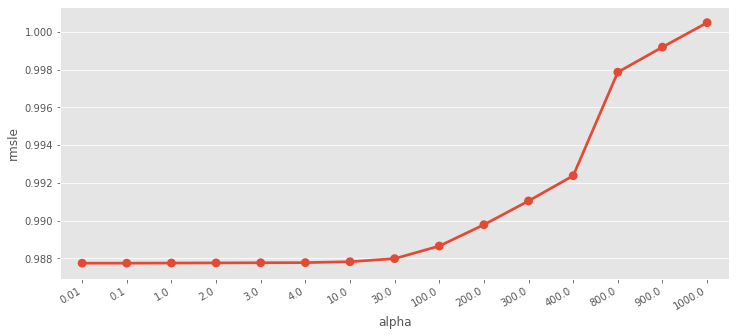

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [22]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457643


,alpha,rmsle
0,10.000000,1.397134
1,1.000000,1.071961
2,0.500000,1.062121
3,0.333333,1.060826
4,0.250000,1.061149


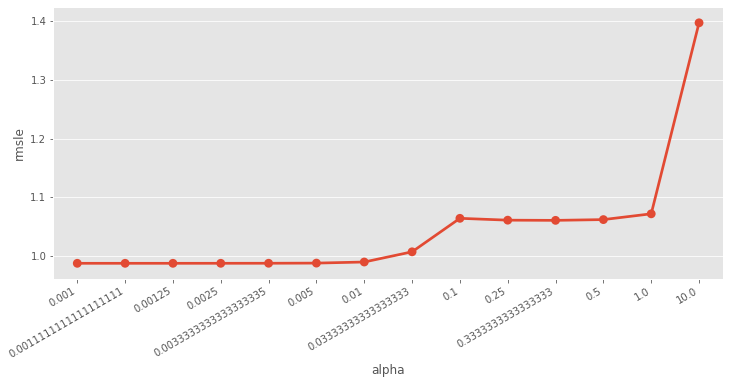

In [23]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [29]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10679392254481175


In [25]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.2135740372724937


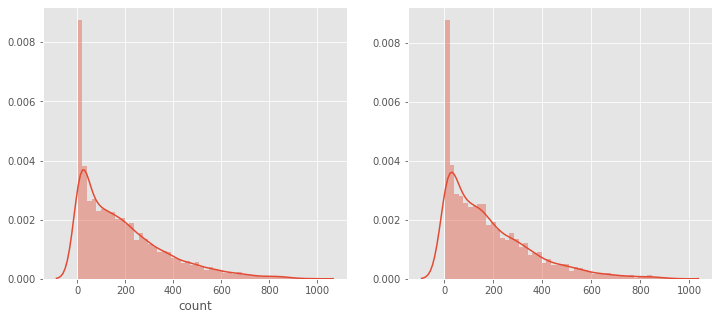

In [30]:
# predsTest = gbm.predict(X_test)
predsTest =rfModel.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [31]:
submission = pd.read_csv("./bike_sharing_demand/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.713119
1,2011-01-20 01:00:00,5.617835
2,2011-01-20 02:00:00,3.887628
3,2011-01-20 03:00:00,4.748731
4,2011-01-20 04:00:00,3.833202


In [32]:
submission.to_csv("./bike_sharing_demand/Score_{0:.5f}_submission.csv".format(score), index=False)